## 含并行连接的网络（GoogLeNet）

GoogLeNet吸收了NiN中串联网络的思想，并在此基础上做了改进。这篇论文的一个重点是解决了什么样大小的卷积核最合适的问题。本文的一个观点是：有时使用不同大小的卷积核组合是有利的。

### Inception块

在GoogLeNet中，基本的卷积块被称为Inception块（Inception block）。

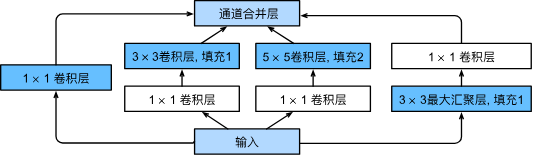

Inception块由四条并行路径组成。前三条路径使用窗口大小为$1×1$、$3×3$和$5×5$的卷积层，从不同空间大小中提取信息。中间的两条路径在输入上执行$1×1$卷积，以减少通道数，从而降低模型的复杂性。第四条路径使用$3×3$最大汇聚层，然后使用$1×1$卷积层来改变通道数。这四条路经都使用合适的填充来使输入与输出的高和宽一致，最后将每条线路的输出在通道维度上连接，并构成Inception块的输出。

在Inception块中，通常调整的超参数是每层输出通道数。

In [1]:
import torch
from torch import nn
from torch.nn import functional as F
from d2l import torch as d2l

class Inception(nn.Module):
    # c1--c4是每条路径的输出通道数
    def __init__(self, in_channels, c1, c2, c3, c4, **kwargs):
        super(Inception, self).__init__(**kwargs)
        # 线路1，单1×1卷积层
        self.p1_1 = nn.Conv2d(in_channels, c1, kernel_size = 1)
        # 线路2，1×1卷积层后接3×3卷积层
        self.p2_1 = nn.Conv2d(in_channels, c2[0], kernel_size = 1)
        self.p2_2 = nn.Conv2d(c2[0], c2[1], kernel_size = 3, padding = 1)
        # 线路3，1×1卷积层后接5×5卷积层
        self.p3_1 = nn.Conv2d(in_channels, c3[0], kernel_size = 1)
        self.p3_2 = nn.Conv2d(c3[0], c3[1], kernel_size = 5, padding = 2)
        # 线路4，3×3最大汇聚层后接1×1卷积层
        self.p4_1 = nn.MaxPool2d(kernel_size = 3, stride = 1, padding = 1)
        self.p4_2 = nn.Conv2d(in_channels, c4, kernel_size = 1)
        
    def forward(self, x):
        p1 = F.relu(self.p1_1(x))
        p2 = F.relu(self.p2_2(F.relu(self.p2_1(x))))
        p3 = F.relu(self.p3_2(F.relu(self.p3_1(x))))
        p4 = F.relu(self.p4_2(self.p4_1(x)))
        # 在通道维度上连接输出
        return torch.cat((p1, p2, p3, p4), dim = 1)

### GoogLeNet模型

GoogLeNet一共使用9个Inception块和全局平均汇聚层的堆叠来生成其估计值。

Inception块之间的最大汇聚层可降低维度。第一个模块类似于AlexNet和LeNet，Inception块的组合从VGG继承，全局平均汇聚层避免了在最后使用全连接层。

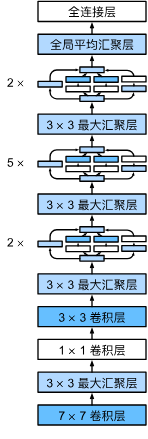

第一个模块使用64个通道、$7×7$卷积层。

In [3]:
b1 = nn.Sequential(nn.Conv2d(1, 64, kernel_size = 7, stride = 2, padding = 3),
                  nn.ReLU(),
                  nn.MaxPool2d(kernel_size = 3, stride = 2, padding = 1))

第二个模块使用两个卷积层：第一个卷积层是64通道、$1×1$卷积层；第二个卷积层使用将通道数量增加三倍的$3×3$卷积层。这对应于Inception块的第二条路径。

In [4]:
b2 = nn.Sequential(nn.Conv2d(64, 64, kernel_size = 1),
                  nn.ReLU(),
                  nn.Conv2d(64, 192, kernel_size = 3, padding = 1),
                  nn.ReLU(),
                  nn.MaxPool2d(kernel_size = 3, stride = 2, padding = 1))

第三个模块串联两个完整的Inception块。

第一个Inception块的输出通道数为$64+128+32+32=256$，四个路径之间的输出通道数量比为$64:128:32:32=2:4:1:1$。第二个和第三个路径首先将输入通道的数量分别减少到$96/192=1/2$和$16/192=1/12$，然后连接第二个卷积层。

第二个Inception块的输出通道数增加到$128+192+96+64=480$，四个路径之间的输出通道数量比为$128:192:96:64=4:6:3:2$。第二条和第三条路径首先将输入通道的数量分别减少到$128/256=1/2$和$32/256=1/8$。

In [5]:
b3 = nn.Sequential(Inception(192, 64, (96, 128), (16, 32), 32),
                  Inception(256, 128, (128, 192), (32, 96), 64),
                  nn.MaxPool2d(kernel_size = 3, stride = 2, padding = 1))

第四模块更加复杂，
它串联了5个Inception块，其输出通道数分别是$192+208+48+64=512$、$160+224+64+64=512$、$128+256+64+64=512$、$112+288+64+64=528$和$256+320+128+128=832$。

这些路径的通道数分配和第三模块中的类似，首先是含$3×3$卷积层的第二条路径输出最多通道，其次是仅含$1×1$卷积层的第一条路径，之后是含$5×5$卷积层的第三条路径和含$3×3$最大汇聚层的第四条路径。

其中第二、第三条路径都会先按比例减小通道数。
这些比例在各个Inception块中都略有不同。


In [6]:
b4 = nn.Sequential(Inception(480, 192, (96, 208), (16, 48), 64),
                   Inception(512, 160, (112, 224), (24, 64), 64),
                   Inception(512, 128, (128, 256), (24, 64), 64),
                   Inception(512, 112, (144, 288), (32, 64), 64),
                   Inception(528, 256, (160, 320), (32, 128), 128),
                   nn.MaxPool2d(kernel_size=3, stride=2, padding=1))

第五模块包含输出通道数为$256+320+128+128=832$和$384+384+128+128=1024$的两个Inception块。

其中每条路径通道数的分配思路和第三、第四模块中的一致，只是在具体数值上有所不同。

第五模块的后面紧跟输出层，该模块同NiN一样使用全局平均汇聚层，将每个通道的高和宽变成1。

最后我们将输出变成二维数组，再接上一个输出个数为标签类别数的全连接层。


In [7]:
b5 = nn.Sequential(Inception(832, 256, (160, 320), (32, 128), 128),
                   Inception(832, 384, (192, 384), (48, 128), 128),
                   nn.AdaptiveAvgPool2d((1,1)),
                   nn.Flatten())

net = nn.Sequential(b1, b2, b3, b4, b5, nn.Linear(1024, 10))

In [8]:
X = torch.rand(size=(1, 1, 96, 96))
for layer in net:
    X = layer(X)
    print(layer.__class__.__name__,'output shape:\t', X.shape)

Sequential output shape:	 torch.Size([1, 64, 24, 24])
Sequential output shape:	 torch.Size([1, 192, 12, 12])
Sequential output shape:	 torch.Size([1, 480, 6, 6])
Sequential output shape:	 torch.Size([1, 832, 3, 3])
Sequential output shape:	 torch.Size([1, 1024])
Linear output shape:	 torch.Size([1, 10])


### 训练模型

使用Fashion-MNIST数据集训练模型。在训练前，将图片转换为$96×96$分辨率。

training on cpu


KeyboardInterrupt: 

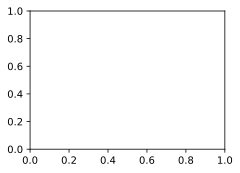

In [9]:
lr, num_epochs, batch_size = 0.1, 10, 128
train_iter, test_iter = d2l.load_data_fashion_mnist(batch_size, resize = 96)
d2l.train_ch6(net, train_iter, test_iter, num_epochs, lr, d2l.try_gpu())